# Customer Conversion ML Framework - Demonstration

## Overview

This notebook demonstrates the ML framework I've built for HubSpot's customer conversion prediction. The framework is designed to:

1. **Enable rapid experimentation** through config-driven workflows
2. **Ensure reproducibility** with versioned artifacts and deterministic training
3. **Support extensibility** via protocol-based abstractions
4. **Facilitate deployment** with clean serving interfaces

### Key Design Decisions

**Configuration-Driven Architecture**
- All experiment parameters in YAML files
- Changes don't require code modifications
- Perfect for data scientists who want to iterate quickly

**Protocol-Based Abstractions**
- Loose coupling between components
- Easy to swap implementations (data sources, models, etc.)
- Testable and maintainable

**Production-Ready From Day One**
- Type hints throughout
- Comprehensive logging
- Artifact versioning
- Clear interfaces for deployment

Let's walk through the framework!

## Setup

In [1]:
import os
print(f"Current directory: {os.getcwd()}")
print(f"Files in current directory: {os.listdir('.')}")
print(f"Data folder exists: {os.path.exists('data')}")

# If you're in notebooks/, change directory
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
    print(f"✓ Changed to: {os.getcwd()}")

Current directory: C:\Users\Jahnavi Gajula\Hubspot_Assesment\ml-framework-package\notebooks
Files in current directory: ['.ipynb_checkpoints', 'artifacts', 'demo.ipynb']
Data folder exists: False
✓ Changed to: C:\Users\Jahnavi Gajula\Hubspot_Assesment\ml-framework-package


In [2]:
import os
import sys

# Ensure we're in project root
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

print(f"✓ Working directory: {os.getcwd()}")
print(f"✓ Data files exist: {os.path.exists('data/customers.csv')}")

# Add src to path so imports work
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

✓ Working directory: C:\Users\Jahnavi Gajula\Hubspot_Assesment\ml-framework-package
✓ Data files exist: True


In [3]:
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src to path for imports
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Framework imports
from ml_framework.utils import load_config, print_metrics_summary
from ml_framework.data import HubSpotDataLoader
from ml_framework.training import Trainer
from ml_framework.serving import Predictor

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Framework imported successfully")

✅ Framework imported successfully


## Part 1: Data Exploration

Let's first understand the data we're working with.

In [4]:
# Load raw data
customers = pd.read_csv('data/customers.csv')
noncustomers = pd.read_csv('data/noncustomers.csv')
usage = pd.read_csv('data/usage_actions.csv')

print(f"Customers: {len(customers):,}")
print(f"Non-customers: {len(noncustomers):,}")
print(f"Usage records: {len(usage):,}")
print(f"\nClass balance: {len(customers)/(len(customers)+len(noncustomers)):.1%} customers")

Customers: 200
Non-customers: 5,003
Usage records: 25,387

Class balance: 3.8% customers


In [5]:
# Examine customer data
print("Customer Data Sample:")
print(customers.head())
print("\nNon-Customer Data Sample:")
print(noncustomers.head())
print("\nUsage Data Sample:")
print(usage.head())

Customer Data Sample:
    CLOSEDATE     MRR  ALEXA_RANK EMPLOYEE_RANGE               INDUSTRY   id
0  2019-06-20  290.00      309343    201 to 1000                  Other  199
1  2019-03-22  392.54    16000001      51 to 200                    NaN  147
2  2020-01-08  -61.15       60502  1001 to 10000       HIGHER_EDUCATION  118
3  2019-09-19  400.00     3575321    201 to 1000      CONSUMER_SERVICES  126
4  2019-01-27  209.98      273063       26 to 50  Technology - Software  174

Non-Customer Data Sample:
   ALEXA_RANK EMPLOYEE_RANGE              INDUSTRY    id
0   4489573.0       11 to 25                   NaN  4916
1   4027013.0        6 to 10                   NaN  3489
2  16000001.0       26 to 50     COMPUTER_SOFTWARE  2813
3    814822.0  1001 to 10000  HOSPITAL_HEALTH_CARE   727
4  16000001.0       26 to 50                   NaN  2166

Usage Data Sample:
            WHEN_TIMESTAMP  ACTIONS_CRM_CONTACTS  ACTIONS_CRM_COMPANIES  \
0  2020-06-01 00:00:00.000                   278    

## Part 2: Framework-Based Data Loading

The `HubSpotDataLoader` handles all data loading and feature engineering automatically.

**Key Features:**
- Merges multiple data sources
- Aggregates usage features automatically
- Creates derived features (engagement metrics, temporal patterns)
- Handles missing data gracefully

In [6]:
# Initialize data loader
loader = HubSpotDataLoader(
    customers_path='data/customers.csv',
    noncustomers_path='data/noncustomers.csv',
    usage_path='data/usage_actions.csv',
    lookback_days=30
)

# Load and prepare data
X, y = loader.load_and_prepare()

print(f"\nFinal dataset shape: {X.shape}")
print(f"Features: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")
print(f"\nFeature columns:")
print(X.columns.tolist()[:20], "...")


customers validation WARNINGS:
  ⚠️  Found 4 customers (2.0%) with MRR ≤ 0 (pipeline will clean these)

noncustomers validation WARNINGS:
  ⚠️  Soft uniqueness check failed for key ('id',): 3 duplicates found (acceptable but flagged)

⚠️  DUPLICATES FOUND: noncustomers
Found 6 duplicate rows for key=['id']
Unique IDs affected: 3
Strategy 'most_complete' will be applied.


Sample duplicate groups:
      id  _duplicate_group
447  278                 0
446  278                 0
923  279                 1
922  279                 1
443  280                 2
444  280                 2

🗑️  Removed 3 duplicate rows

⚠️  Found 4 customers with MRR <= 0 (2.00%)
Business rule: Customers (is_customer = 1) must have MRR > 0

Sample invalid rows:
     id     MRR
2   118  -61.15
5   141 -403.20
6   197 -260.00
19    3 -555.00

🗑️  Removed 4 invalid customers



Final dataset shape: (5196, 36)
Features: 36
Samples: 5196

Feature columns:
['ALEXA_RANK', 'EMPLOYEE_RANGE', 'INDUSTRY', 'ACTIONS_CRM_CONTACTS_sum', 'ACTIONS_CRM_CONTACTS_mean', 'ACTIONS_CRM_CONTACTS_max', 'ACTIONS_CRM_CONTACTS_std', 'ACTIONS_CRM_COMPANIES_sum', 'ACTIONS_CRM_COMPANIES_mean', 'ACTIONS_CRM_COMPANIES_max', 'ACTIONS_CRM_COMPANIES_std', 'ACTIONS_CRM_DEALS_sum', 'ACTIONS_CRM_DEALS_mean', 'ACTIONS_CRM_DEALS_max', 'ACTIONS_CRM_DEALS_std', 'ACTIONS_EMAIL_sum', 'ACTIONS_EMAIL_mean', 'ACTIONS_EMAIL_max', 'ACTIONS_EMAIL_std', 'USERS_CRM_CONTACTS_sum'] ...


## Part 3: Configuration-Driven Training

Everything is controlled via a YAML config file. Let's examine it:

In [7]:
# Display config file
with open('configs/config.yaml', 'r') as f:
    config_content = f.read()

print("Configuration File:")
print("=" * 60)
print(config_content[:1500])  # Show first part
print("\n... (truncated for display)")

Configuration File:
# ML Framework Configuration
# This config file drives all experiments - change parameters here rather than in code

# Experiment metadata
experiment:
  name: "customer_conversion_baseline"
  description: "Baseline model predicting customer conversion from usage patterns"
  tags: ["baseline", "logistic_regression"]

# Data configuration
data:
  # Input data paths (relative to project root)
  customers_path: "data/customers.csv"
  noncustomers_path: "data/noncustomers.csv"
  usage_actions_path: "data/usage_actions.csv"
  
  # Train/test split
  test_size: 0.2
  random_state: 42
  stratify: true  # Stratify by target variable
  
  # Feature engineering
  features:
    # Aggregation window for usage features (in days)
    lookback_days: 30
    industry_min_frequency: 5
    
    # Feature scaling
    scaling:
      method: "standard"  # Options: standard, minmax, robust, none
      exclude_columns: []  # Columns to exclude from scaling
    
    missing_values:
      str

### Training the Model

The `Trainer` class orchestrates the entire pipeline:
1. Loads data
2. Splits train/test
3. Preprocesses features
4. Trains model
5. Evaluates performance
6. Saves all artifacts

**All controlled by the config file!**

In [8]:
# Load configuration
config = load_config('configs/config.yaml')

# Create trainer
trainer = Trainer(config)

# Train model (this runs the entire pipeline)
results = trainer.train(X=X, y=y)

2025-11-09 11:12:36 - experiment.customer_conversion_baseline - INFO - Experiment 'customer_conversion_baseline' initialized
2025-11-09 11:12:36 - experiment.customer_conversion_baseline - INFO - Set random seed: 42
2025-11-09 11:12:36 - experiment.customer_conversion_baseline - INFO - Artifact directory: artifacts\customer_conversion_baseline_20251109_111236
2025-11-09 11:12:36 - experiment.customer_conversion_baseline - INFO - Trainer initialized for experiment: customer_conversion_baseline
2025-11-09 11:12:36 - experiment.customer_conversion_baseline - INFO - ============================================================
2025-11-09 11:12:36 - experiment.customer_conversion_baseline - INFO - Starting experiment: customer_conversion_baseline
2025-11-09 11:12:36 - experiment.customer_conversion_baseline - INFO - ============================================================
2025-11-09 11:12:36 - experiment.customer_conversion_baseline - INFO - Using pre-loaded data: 5196 samples, 36 featur

### Examining Results

In [9]:
# Display metrics
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)

metrics = results['metrics']
for metric, value in metrics.items():
    if value is not None:
        print(f"{metric.upper():<25} {value:.4f}")

# Cross-validation results
if results.get('cv_results'):
    cv = results['cv_results']
    print(f"\nCROSS-VALIDATION (5-fold)")
    print(f"Mean ROC-AUC: {cv['cv_mean']:.4f} (+/- {cv['cv_std']:.4f})")

print(f"\nArtifacts saved to: {results['artifact_dir']}")


MODEL PERFORMANCE SUMMARY
ACCURACY                  0.9442
PRECISION                 0.3827
RECALL                    0.7949
F1                        0.5167
ROC_AUC                   0.9510
AVERAGE_PRECISION         0.6449

CROSS-VALIDATION (5-fold)
Mean ROC-AUC: 0.9617 (+/- 0.0156)

Artifacts saved to: artifacts\customer_conversion_baseline_20251109_111236


### Visualizing Performance

The framework automatically generates comprehensive visualizations:

Confusion Matrix:


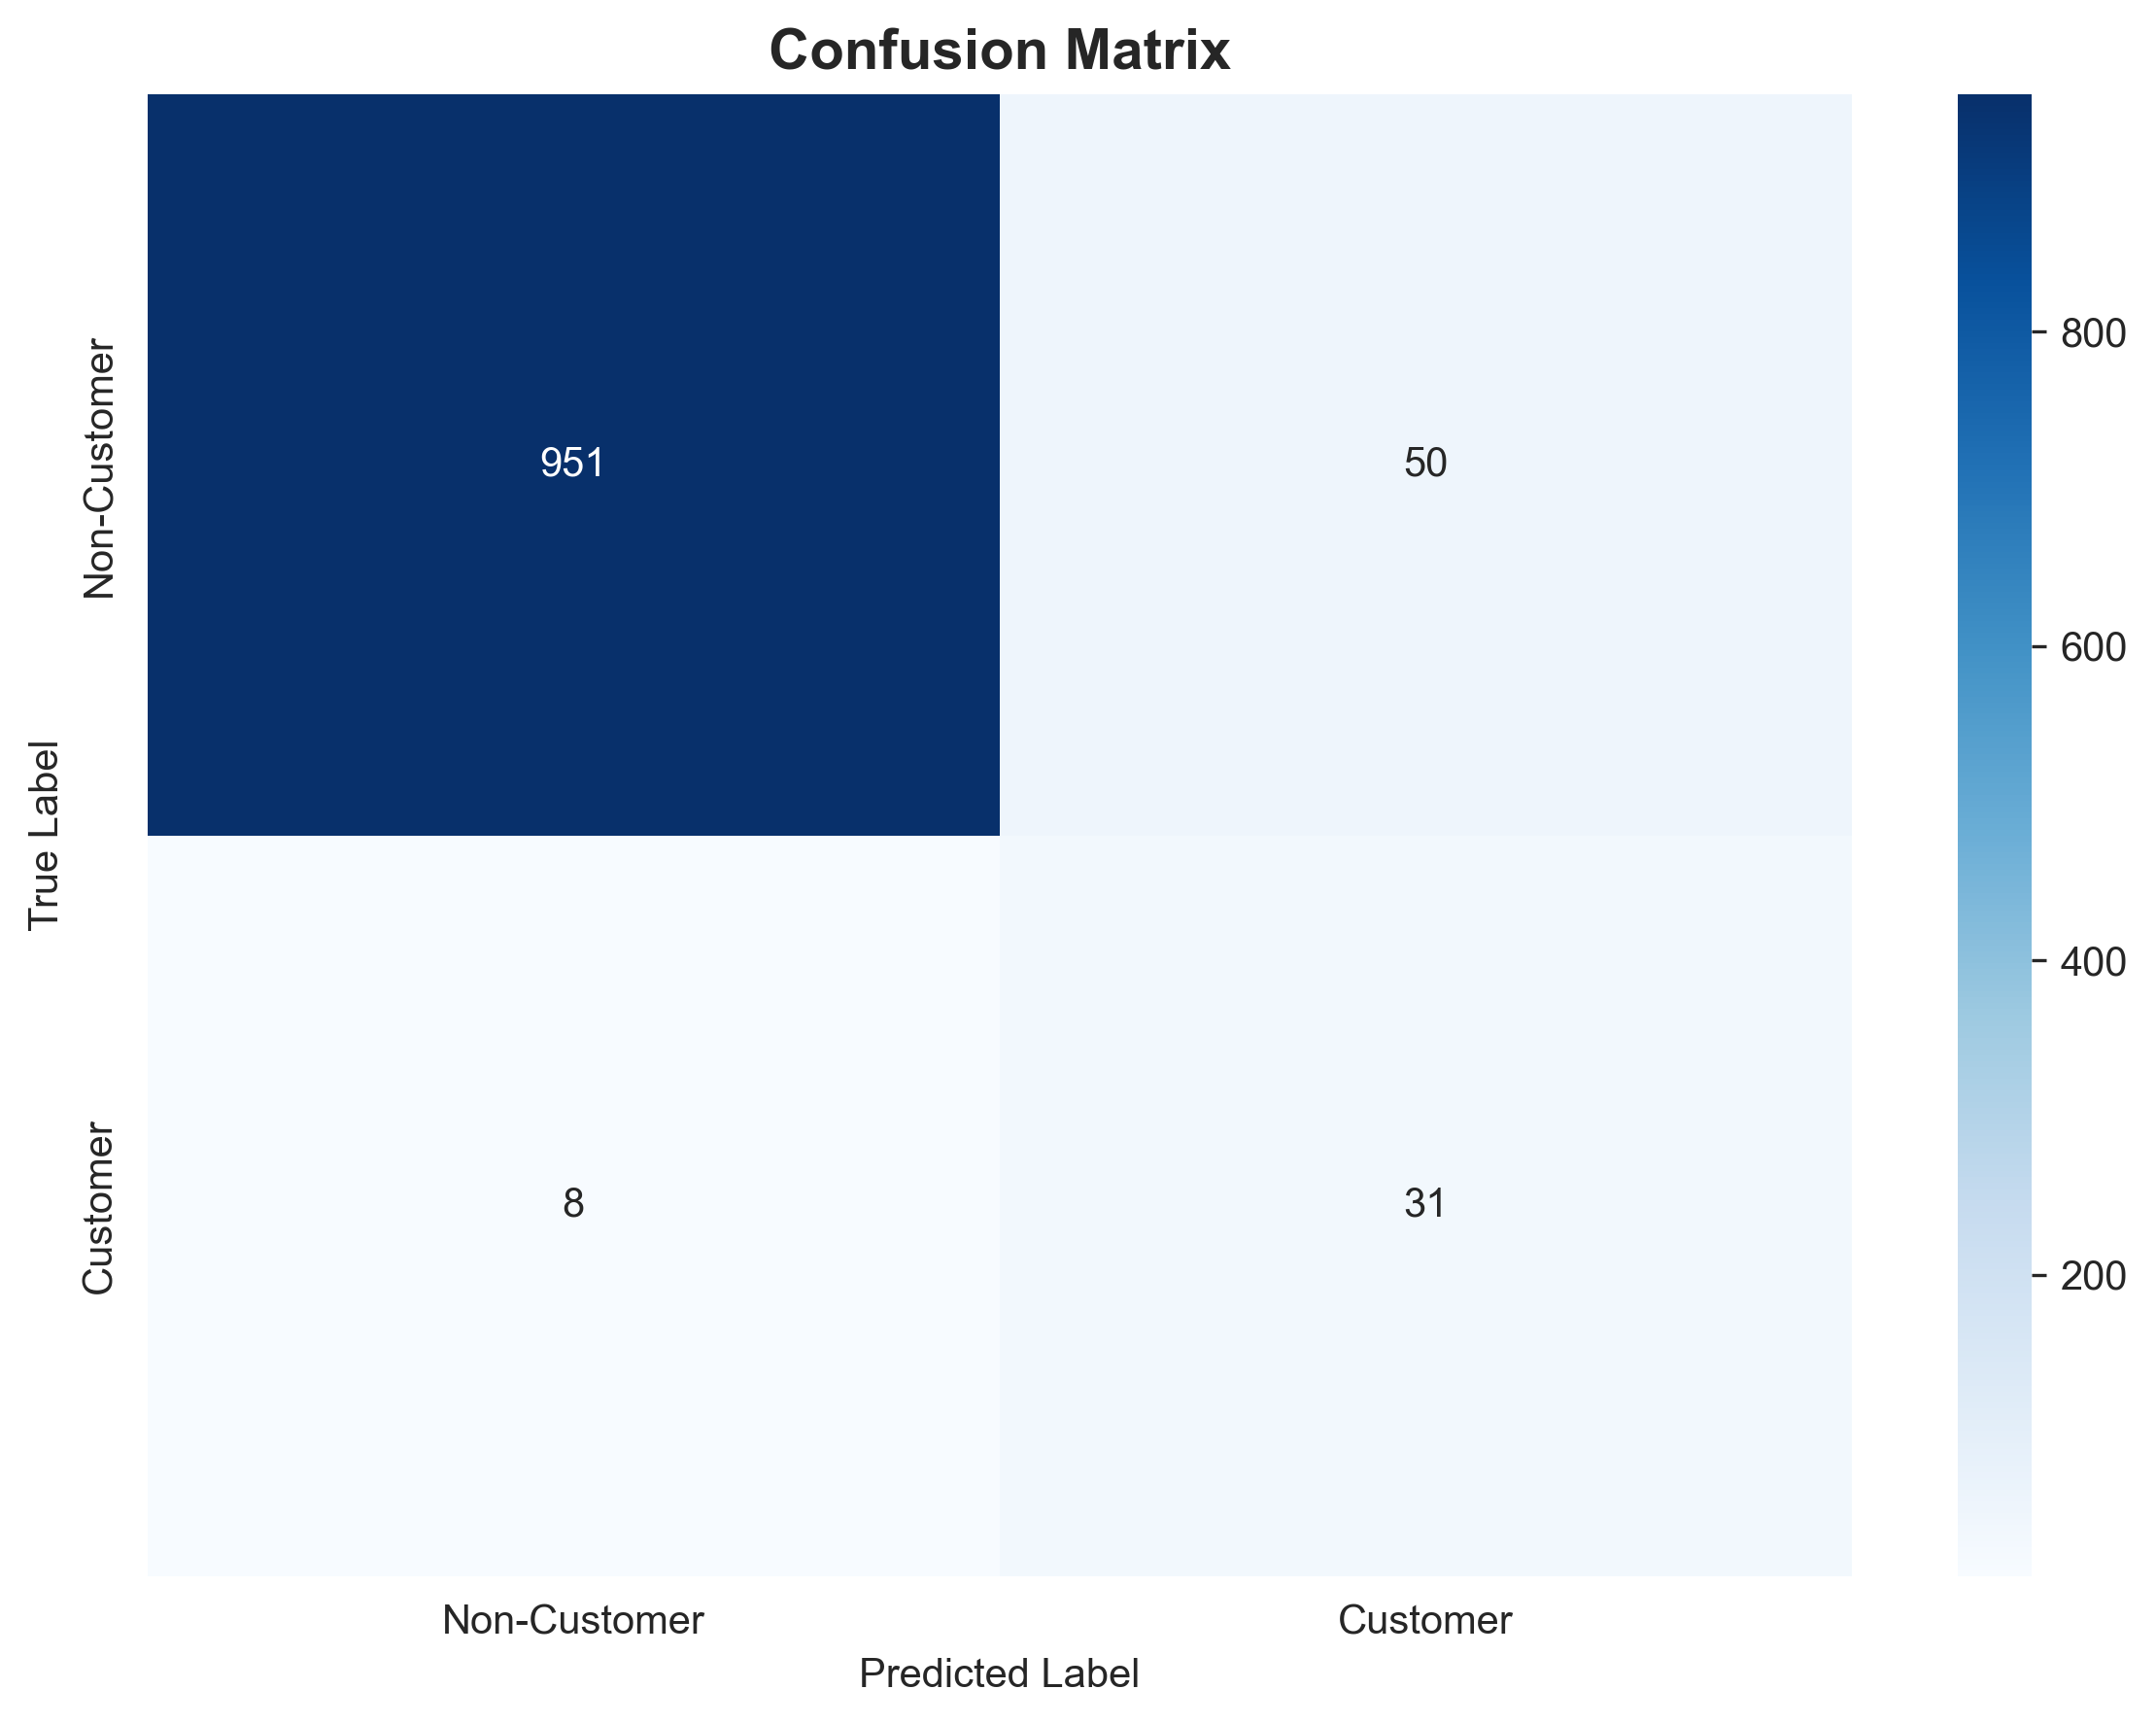


ROC Curve:


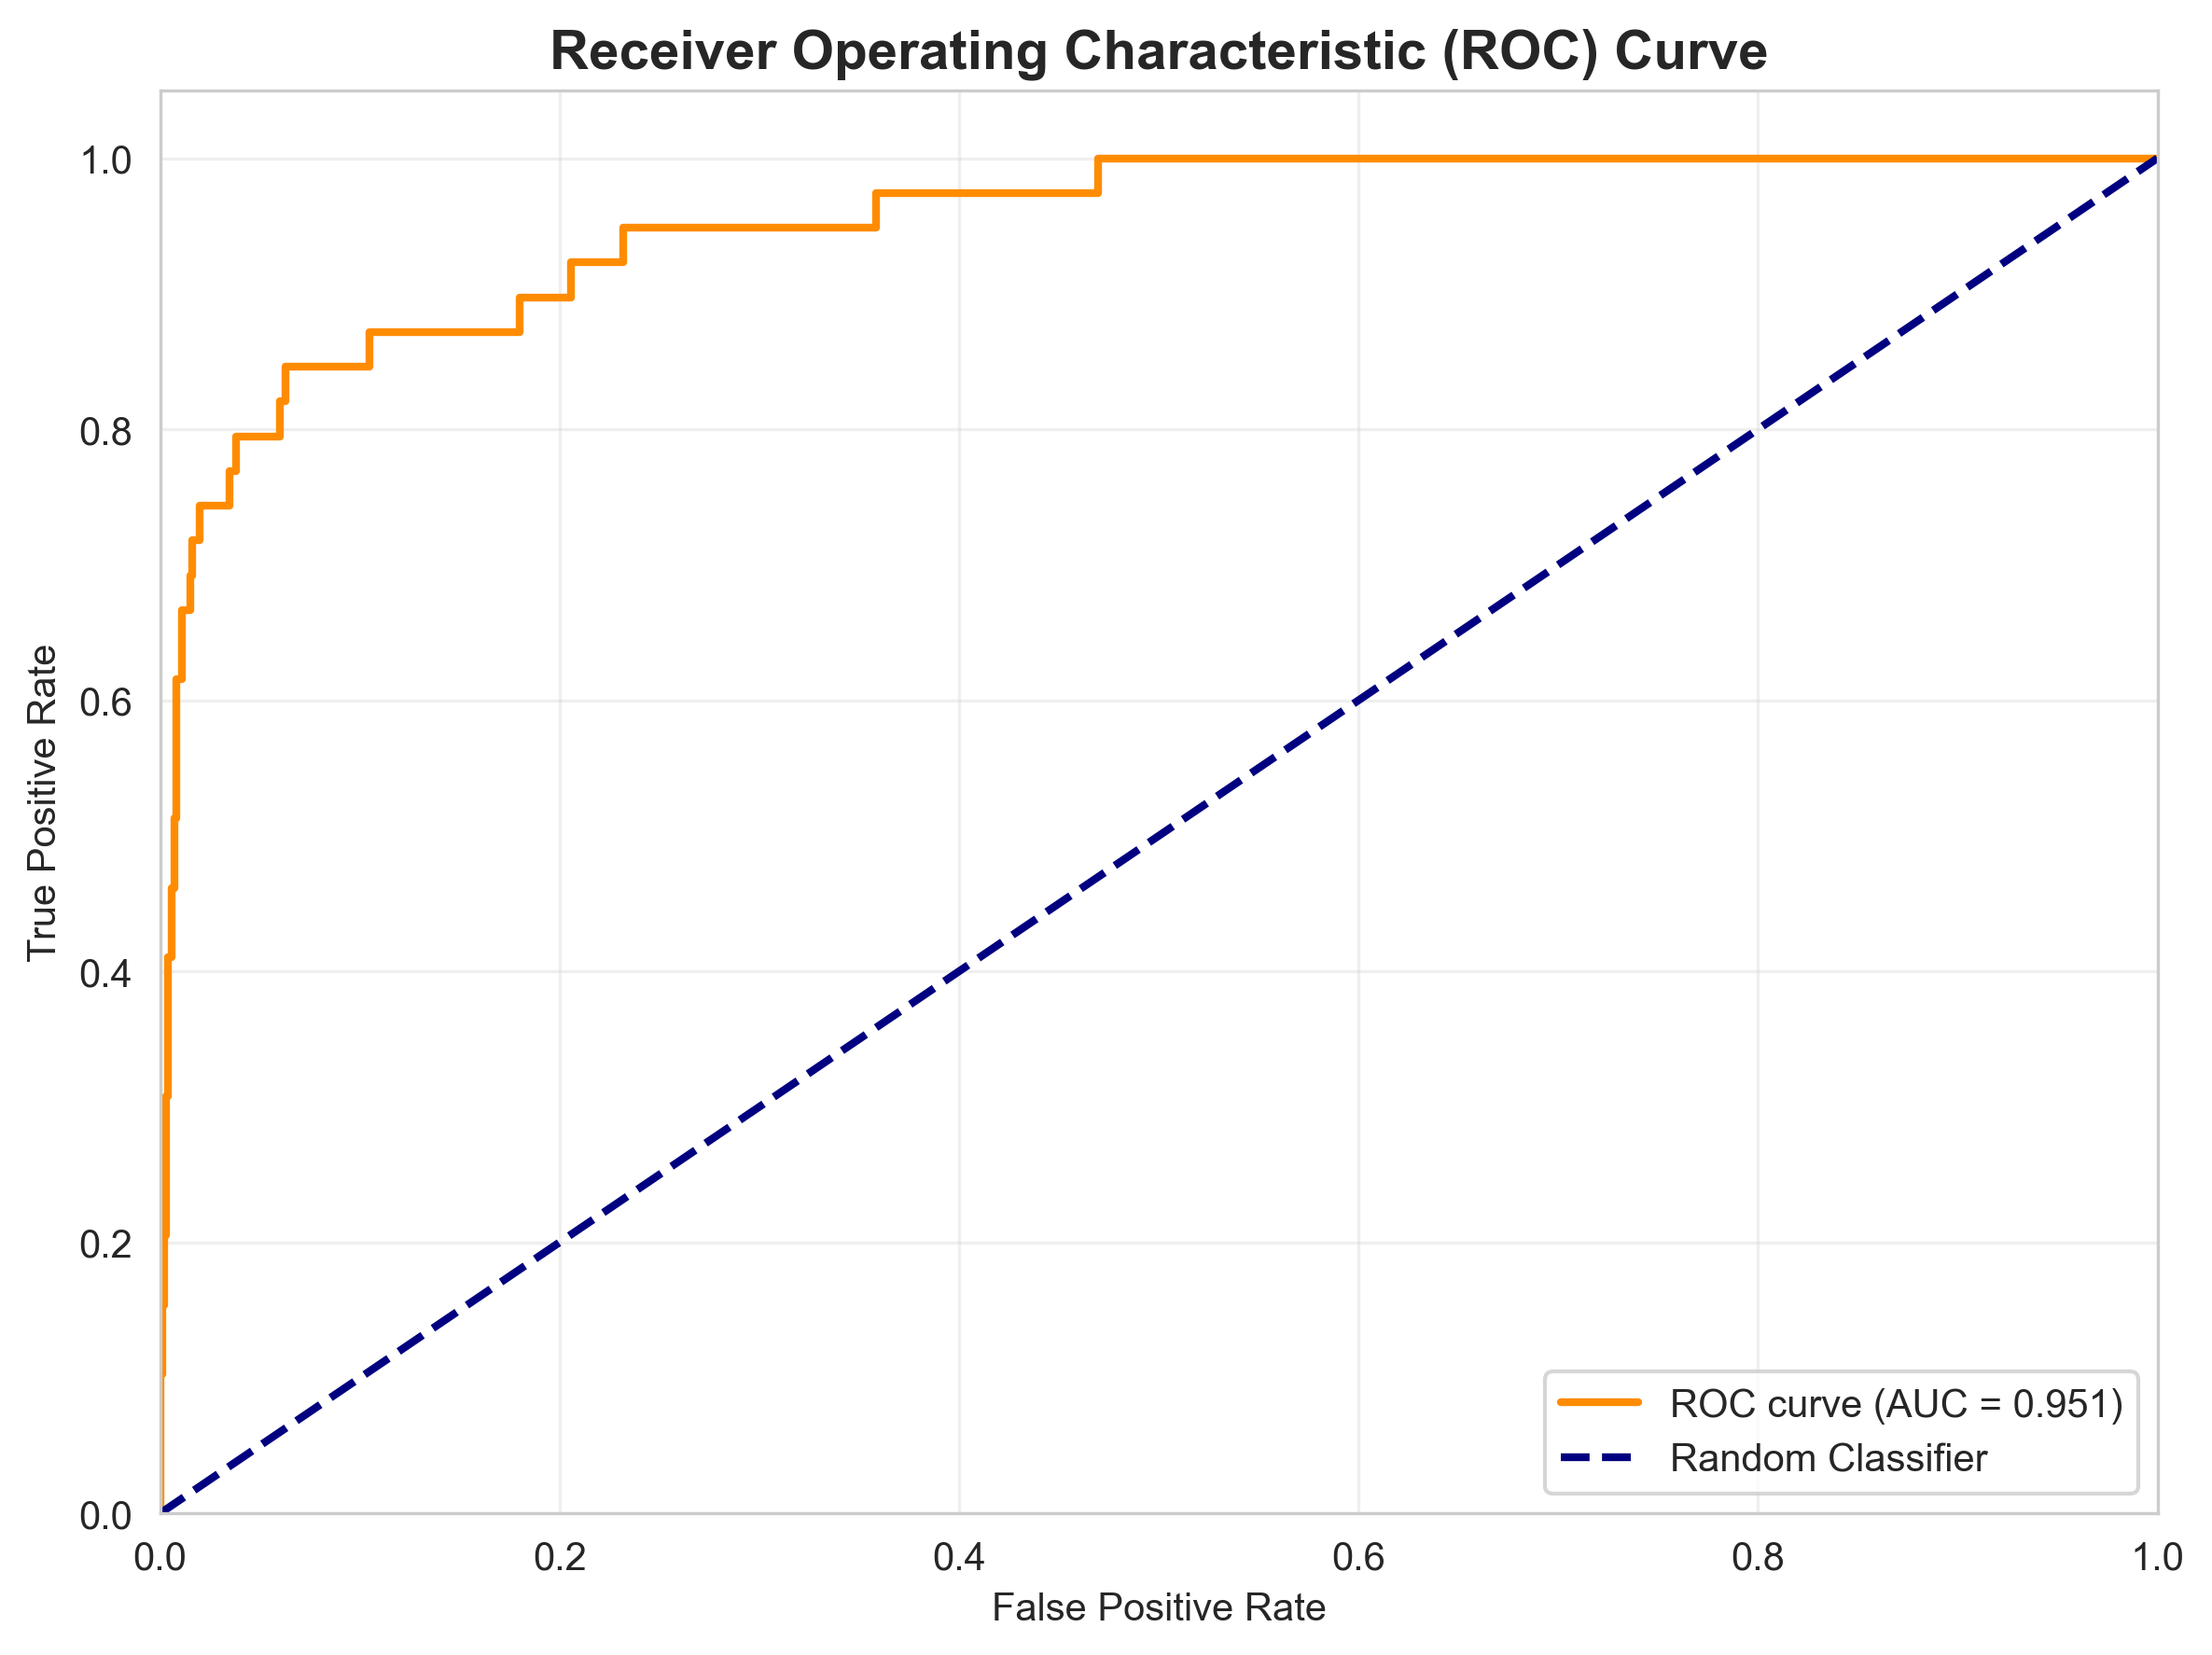


Feature Importance:


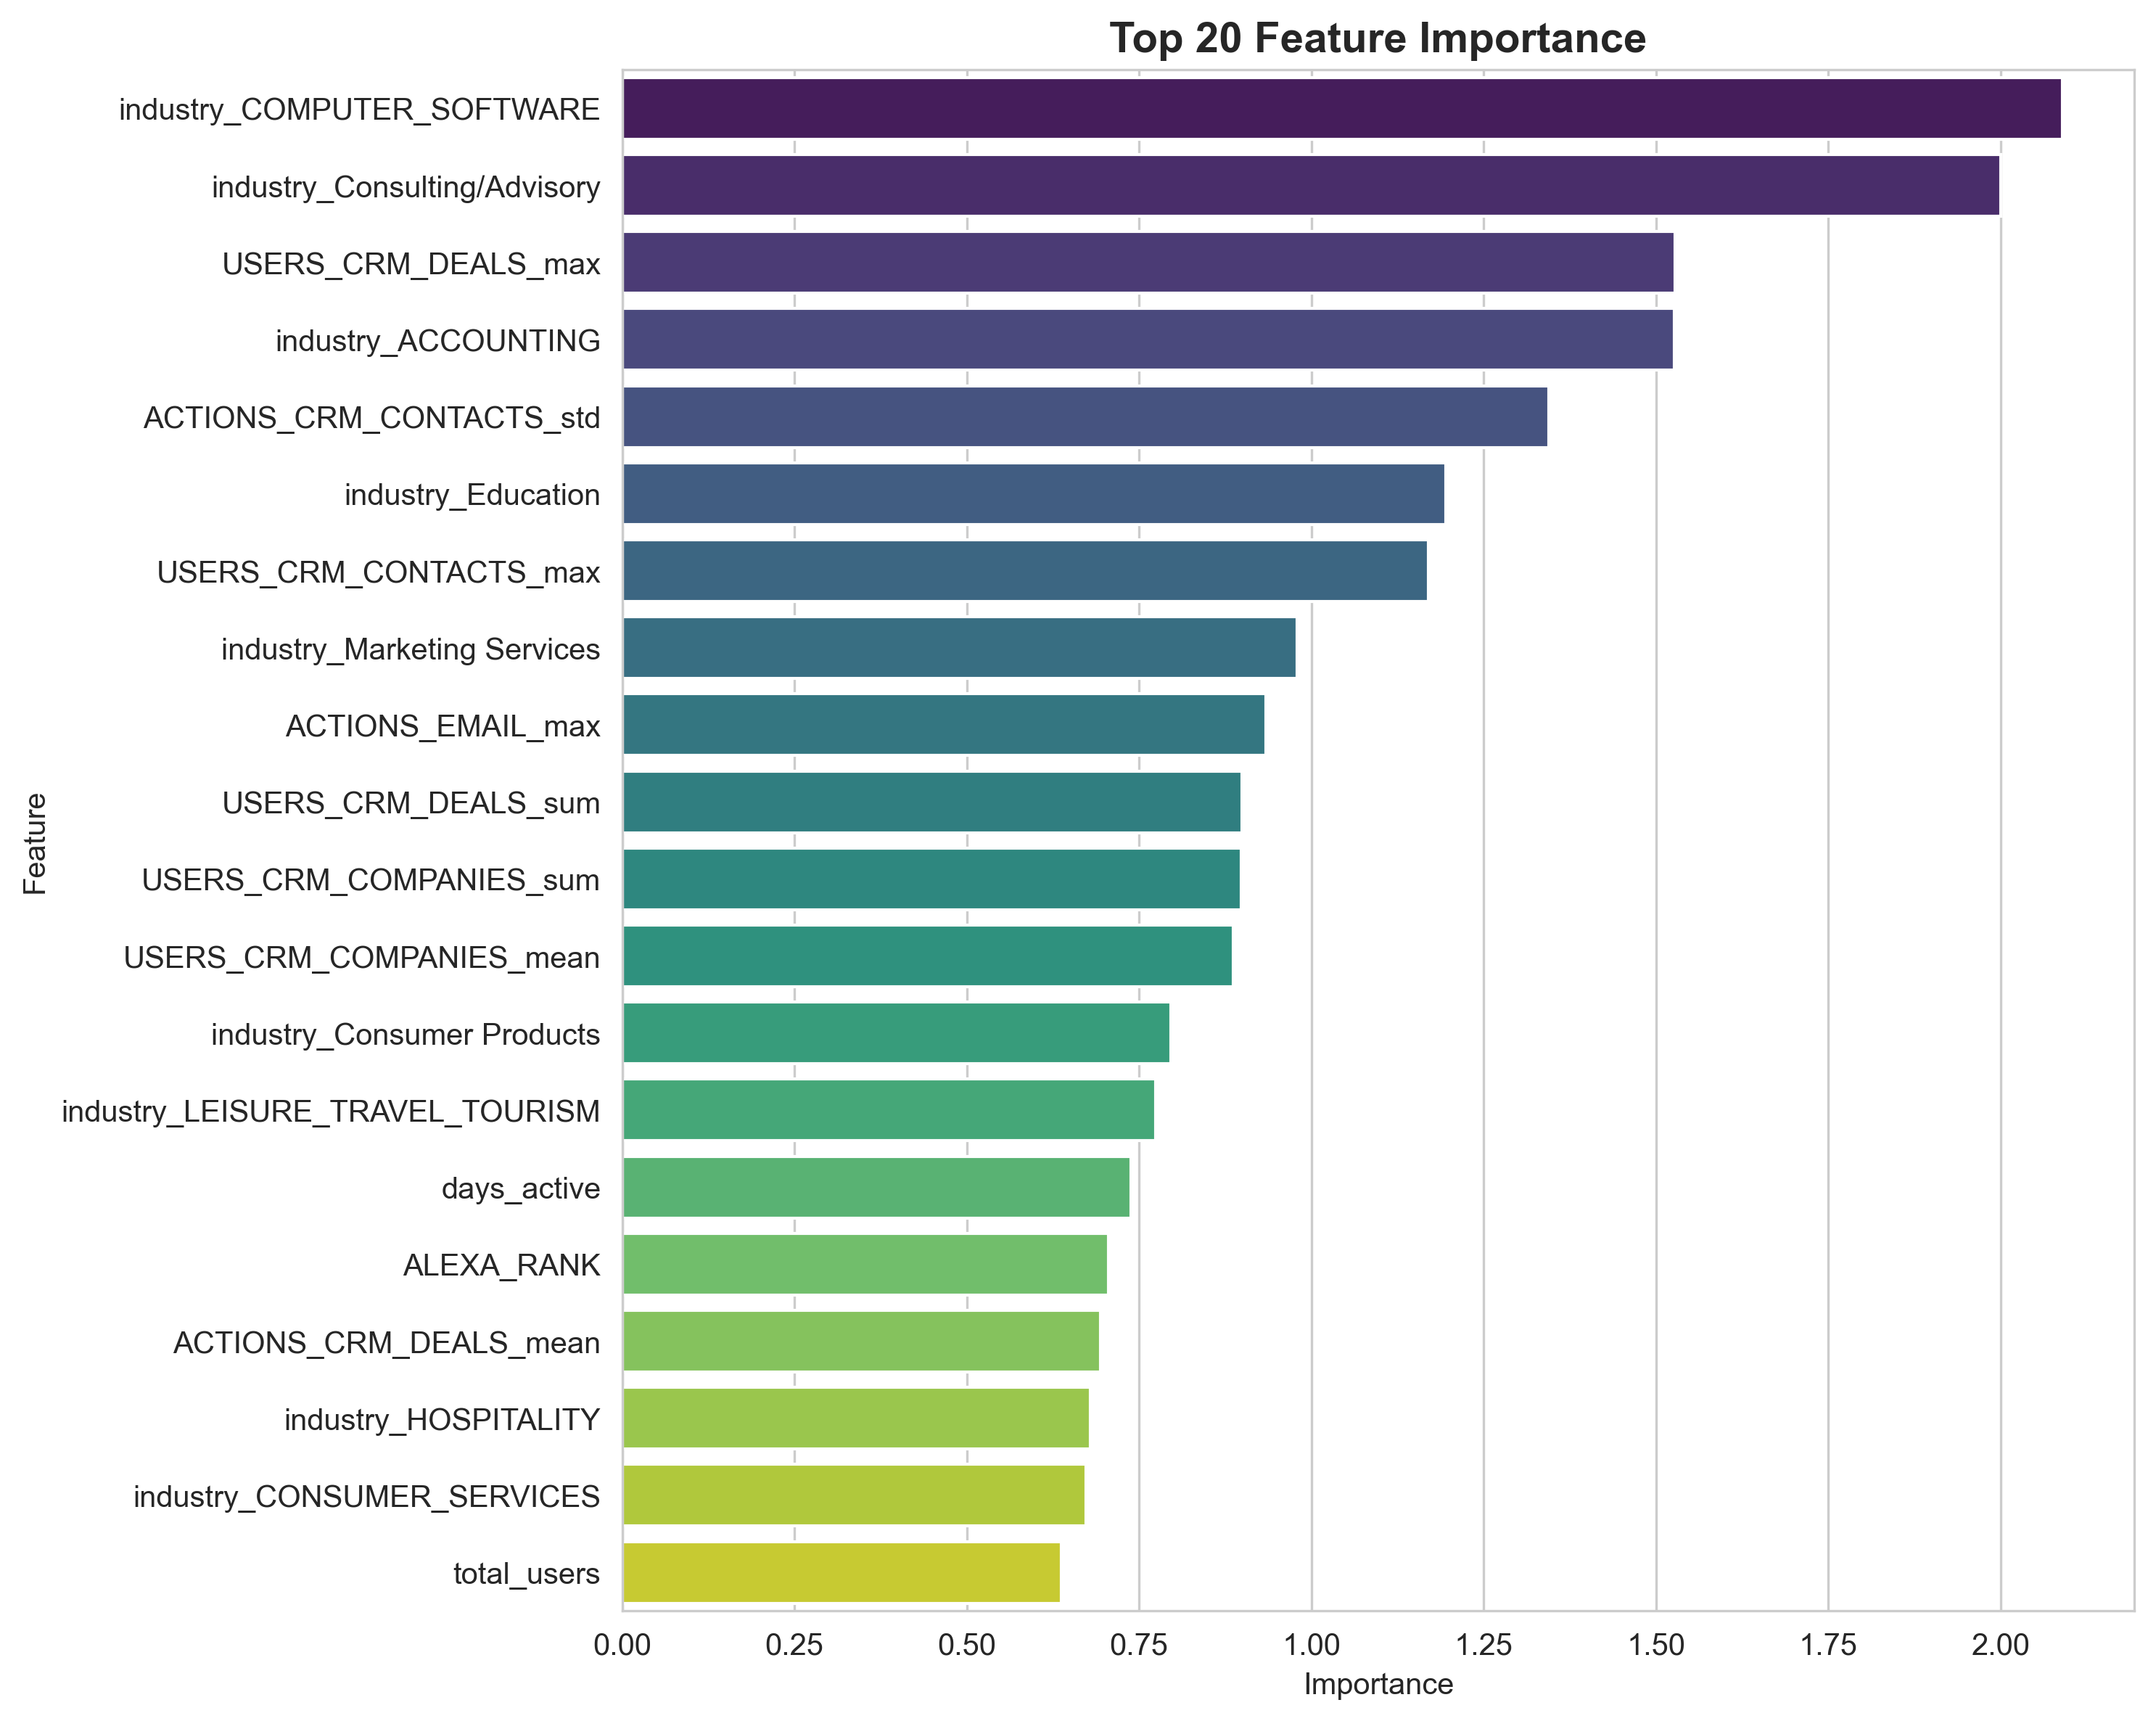

In [10]:
# Display generated plots
from IPython.display import Image, display
import os

plot_dir = os.path.join(results['artifact_dir'], 'plots')

print("Confusion Matrix:")
display(Image(filename=os.path.join(plot_dir, 'confusion_matrix.png')))

print("\nROC Curve:")
display(Image(filename=os.path.join(plot_dir, 'roc_curve.png')))

print("\nFeature Importance:")
display(Image(filename=os.path.join(plot_dir, 'feature_importance.png')))

## Part 4: Model Serving

The `Predictor` class makes it easy to load trained models and make predictions.

**Key Features:**
- Load from any artifact directory
- Make predictions on new data
- Batch processing support
- Export in multiple formats
- Easy integration with serving platforms

In [11]:
# Load the trained model
predictor = Predictor.from_artifact_dir(results['artifact_dir'])

print("✅ Model loaded successfully")
print(f"Model type: {type(predictor.model)}")

✅ Model loaded successfully
Model type: <class 'ml_framework.models.implementations.LogisticRegressionModel'>


In [12]:
# Make predictions on new data (using noncustomers as example)
new_data_loader = HubSpotDataLoader(
    customers_path='data/customers.csv',
    noncustomers_path='data/noncustomers.csv',
    usage_path='data/usage_actions.csv'
)

# Load non-customer data for prediction
all_data = new_data_loader.load_data()
prospects = all_data[all_data['is_customer'] == 0].copy()

# Keep ID column for tracking
prospect_ids = prospects['id'].copy()
prospect_features, _ = new_data_loader.get_features_and_target(prospects)

# Make predictions
predictions = predictor.predict(prospect_features, return_proba=True)

# Add IDs back
predictions.insert(0, 'ID', prospect_ids.values)

print("\nPredictions Sample:")
print(predictions.head(10))


customers validation WARNINGS:
  ⚠️  Found 4 customers (2.0%) with MRR ≤ 0 (pipeline will clean these)

noncustomers validation WARNINGS:
  ⚠️  Soft uniqueness check failed for key ('id',): 3 duplicates found (acceptable but flagged)

⚠️  DUPLICATES FOUND: noncustomers
Found 6 duplicate rows for key=['id']
Unique IDs affected: 3
Strategy 'most_complete' will be applied.


Sample duplicate groups:
      id  _duplicate_group
447  278                 0
446  278                 0
923  279                 1
922  279                 1
443  280                 2
444  280                 2

🗑️  Removed 3 duplicate rows

⚠️  Found 4 customers with MRR <= 0 (2.00%)
Business rule: Customers (is_customer = 1) must have MRR > 0

Sample invalid rows:
     id     MRR
2   118  -61.15
5   141 -403.20
6   197 -260.00
19    3 -555.00

🗑️  Removed 4 invalid customers



Predictions Sample:
    ID  prediction  probability  confidence
0  201           0     0.018570    0.981430
1  202           0     0.019192    0.980808
2  203           1     0.992613    0.992613
3  204           1     0.592792    0.592792
4  205           0     0.094969    0.905031
5  206           0     0.325206    0.674794
6  207           0     0.117750    0.882250
7  208           0     0.020099    0.979901
8  209           0     0.017155    0.982845
9  210           0     0.025464    0.974536


In [13]:
# Find top prospects most likely to convert
top_prospects = predictions.nlargest(20, 'probability')

print("\nTop 20 Prospects Most Likely to Convert:")
print("="*60)
print(top_prospects[['ID', 'prediction', 'probability']].to_string(index=False))

print(f"\n✅ These prospects should be prioritized for sales outreach!")


Top 20 Prospects Most Likely to Convert:
  ID  prediction  probability
5144           1     1.000000
3505           1     0.999999
1902           1     0.999973
 469           1     0.999900
 389           1     0.999783
4140           1     0.999673
1436           1     0.999653
2813           1     0.999545
5013           1     0.999539
4421           1     0.999252
4436           1     0.998310
2227           1     0.997955
4209           1     0.997842
4809           1     0.997518
1640           1     0.994487
 203           1     0.992613
 548           1     0.992084
2311           1     0.991679
2064           1     0.989523
3557           1     0.989054

✅ These prospects should be prioritized for sales outreach!


## Part 5: Framework Extensibility

### How to Add a New Model

The framework is designed for easy extension. Here's how to add a new model:

In [14]:
# Example: Adding a custom model
from ml_framework.models.base import BaseModel

class CustomNeuralNetworkModel(BaseModel):
    """Example of adding a custom model to the framework."""
    
    def __init__(self, **kwargs):
        super().__init__()
        # Initialize your model here
        # self.model = YourCustomModel(**kwargs)
        pass
    
    def fit(self, X, y):
        # Training logic
        # self.model.fit(X, y)
        self._is_fitted = True
        return self
    
    def predict(self, X):
        # Prediction logic
        # return self.model.predict(X)
        pass
    
    def predict_proba(self, X):
        # Probability prediction
        # return self.model.predict_proba(X)
        pass

print("✅ Custom models integrate seamlessly!")
print("\nJust implement the BaseModel interface:")
print("  - fit(X, y)")
print("  - predict(X)")
print("  - predict_proba(X)")

✅ Custom models integrate seamlessly!

Just implement the BaseModel interface:
  - fit(X, y)
  - predict(X)
  - predict_proba(X)


### How to Add Custom Features

Feature transformers are composable and easy to add:

In [15]:
from ml_framework.data.base import FeatureTransformer

class RecencyFeature:
    """Example: Add recency-based features."""
    
    def transform(self, df):
        # Add custom feature logic here
        # df['days_since_last_action'] = ...
        return df

class EngagementScoreFeature:
    """Example: Composite engagement score."""
    
    def transform(self, df):
        # Create composite score
        # df['engagement_score'] = ...
        return df

print("✅ Custom features are simple to add!")
print("\nJust implement the transform() method.")
print("Features are applied in a pipeline, making them composable.")

✅ Custom features are simple to add!

Just implement the transform() method.
Features are applied in a pipeline, making them composable.


## Part 6: Experiment Comparison

Let's demonstrate how easy it is to compare different models:

In [16]:
# Compare different models
from ml_framework.utils import merge_configs

# Base config
base_config = load_config('configs/config.yaml')

# Try Random Forest
rf_override = {
    'experiment': {'name': 'customer_conversion_rf'},
    'model': {
        'type': 'random_forest',
        'hyperparameters': {
            'n_estimators': 100,
            'max_depth': 10,
            'class_weight': 'balanced'
        }
    }
}

# Note: In a real scenario, you'd train this model
# rf_config = merge_configs(base_config, rf_override)
# rf_trainer = Trainer(rf_config)
# rf_results = rf_trainer.train()

print("✅ Config overrides make experimentation trivial!")
print("\nTo compare models:")
print("1. Create config override")
print("2. Merge with base config")
print("3. Train new model")
print("4. Compare artifacts in artifacts/ directory")

✅ Config overrides make experimentation trivial!

To compare models:
1. Create config override
2. Merge with base config
3. Train new model
4. Compare artifacts in artifacts/ directory


## Part 7: Production Integration

### How This Framework Integrates with Production Systems

**1. Model Serving Platform (e.g., SageMaker, Vertex AI)**
```python
# The Predictor class can be wrapped in a REST API
from fastapi import FastAPI
from ml_framework.serving import Predictor

app = FastAPI()
predictor = Predictor.from_artifact_dir('artifacts/latest')

@app.post('/predict')
def predict(data: dict):
    X = pd.DataFrame([data])
    predictions = predictor.predict(X)
    return predictions.to_dict('records')[0]
```

**2. Batch Processing Pipeline**
```python
# Nightly batch predictions
predictor = Predictor.from_artifact_dir('artifacts/prod_model')
prospects = load_from_database()
predictions = predictor.predict_batch(prospects, batch_size=10000)
save_to_database(predictions)
```

**3. Other Data Science Teams**
```python
# Artifacts are self-contained and portable
# Another team can use your trained model:
predictor = Predictor.from_artifact_dir('/shared/models/conversion_model')
predictions = predictor.predict(their_data)
```

## Summary: Framework Benefits

### ✅ For Data Scientists
- **Config-driven experiments**: Change parameters without touching code
- **Fast iteration**: Train multiple models with different configs
- **Reproducible**: Every experiment tracked with versioned artifacts
- **Comprehensive**: Automatic logging, metrics, and visualizations

### ✅ For ML Engineers
- **Clean abstractions**: Protocol-based design for loose coupling
- **Extensible**: Easy to add models, features, data sources
- **Testable**: Clear interfaces enable comprehensive testing
- **Production-ready**: Type hints, error handling, logging

### ✅ For the Organization
- **Standardized**: Consistent approach across projects
- **Portable**: Artifacts work across different systems
- **Scalable**: Designed for growth from prototype to production
- **Maintainable**: Clear structure, documentation, and patterns

## Next Steps (Beyond 5-Hour Scope)

1. **Hyperparameter Optimization**: Integrate Optuna or Ray Tune
2. **Advanced Monitoring**: Drift detection, performance tracking
3. **Feature Store**: Centralized feature management
4. **CI/CD Integration**: Automated testing and deployment
5. **A/B Testing Framework**: Measure model impact systematically
6. **Advanced Explanations**: SHAP values, LIME
7. **API Service**: FastAPI REST endpoint for real-time predictions